Integration of cardiomyocytes from NG (down-sampled) and Paige | Author: Xuezhu Sunny Wang

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(pheatmap)

Warning message:
“package ‘Seurat’ was built under R version 4.2.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.2.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.2.3”
‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


In [2]:
## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [3]:
run_highlight <- function(sce,sample_num,ptsize=2){
  myumap <- sce@reductions$umap@cell.embeddings %>%
    as.data.frame() %>%
    cbind(sample = sce@meta.data$orig.ident)
  all_sample = unique(myumap$sample)
  for (s in all_sample) {
    subumap <- myumap
    subumap$sample <- ifelse(subumap$sample==s,'yes','no')
    p = ggplot(subumap,aes(x= UMAP_1 , y = UMAP_2 ,color = sample)) +
      geom_point(size = ptsize , alpha =2,show.legend = F) +
      scale_color_manual(values = c('yes'='#D95F02','no'='grey65'))+
      labs(title = s)+
      theme_classic()+
      theme(axis.title = element_text(size = 15,colour = 'black'),
            axis.text = element_text(size = 12,colour = 'black'),
            plot.title = element_text(size = 20,colour = 'black',hjust = 0.5))
    ggsave(p,filename=paste0(sample_num,'_fig1_umap_highlight_',s,'.pdf'),width=7,height=7)
  }
}

In [4]:
sce1 <- readRDS('CM_after_reclustering.rds')
sce1

An object of class Seurat 
62959 features across 11058 samples within 2 assays 
Active assay: SCT (29161 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

In [5]:
sce1@active.assay<-'RNA'
sce1

An object of class Seurat 
62959 features across 11058 samples within 2 assays 
Active assay: RNA (33798 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, tsne

In [6]:
load('CP23_no6_postQC_Cluster_res_0.4_noHarmony.RData')
ls()

[1] "StackedVlnPlot" "extract_max"    "modify_vlnplot" "pbmc"          
[5] "run_highlight"  "sce1"

In [7]:
pbmc@active.assay<-'RNA'
pbmc

An object of class Seurat 
27632 features across 16025 samples within 1 assay 
Active assay: RNA (27632 features, 2500 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [8]:
pbmc<-subset(x = pbmc, downsample = 1000)

In [9]:
pbmc

An object of class Seurat 
27632 features across 6311 samples within 1 assay 
Active assay: RNA (27632 features, 2500 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [10]:
sce1 <- subset(sce1, subset = nFeature_RNA < 5500 & nCount_RNA < 15000)

In [11]:
pbmc@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,scrub_score,CMO,Run,run_CMO,SampleName,CellType,Genotype,Project,Owner,percent.mito,Genotype_2,Genotype_3,RNA_snn_res.0.4,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>
CP23_AAACCCAAGATACCAA-1,CP23_filtered,5240,2636,0.03326775,CMO307,CP23,CP23_CMO307,MYOCD_KI43_CMD10,CM_D10,MYOCD_KI43,FX,FX,0.07633588,MYOCD,MYOCD,2,2
CP23_AAACCCAAGTTACGGG-1,CP23_filtered,11274,4790,0.14838394,CMO303,CP23,CP23_CMO303,BCOR_KIpool_CMD10_1,CM_D10,BCOR_KIpool_1,FX,FX,0.46123825,BCOR,BCOR,4,4
CP23_AAACCCACACCGTGAC-1,CP23_filtered,3154,2031,0.05281445,CMO305,CP23,CP23_CMO305,SP2_KI12_CMD10,CM_D10,SP2_KI12,FX,FX,0.57070387,SP2,WT,5,5
CP23_AAACCCACAGCTGTCG-1,CP23_filtered,2352,1516,0.10765141,CMO310,CP23,CP23_CMO310,ADAMTS6_KI5_CMD10,CM_D10,ADAMTS6_KI5,FX,FX,1.31802721,ADAMTS6,ADAMTS6,2,2
CP23_AAACCCAGTATCAGCT-1,CP23_filtered,3387,2129,0.09856153,CMO304,CP23,CP23_CMO304,BCOR_KIpool_CMD10_2,CM_D10,BCOR_KIpool_2,FX,FX,0.38382049,BCOR,BCOR,4,4
CP23_AAACCCAGTGGCTTGC-1,CP23_filtered,1141,809,0.07429399,CMO304,CP23,CP23_CMO304,BCOR_KIpool_CMD10_2,CM_D10,BCOR_KIpool_2,FX,FX,0.61349693,BCOR,BCOR,2,2
CP23_AAACCCATCTAGCAAC-1,CP23_filtered,13439,4712,0.05372820,CMO301,CP23,CP23_CMO301,WT_CMD10_1,CM_D10,WT,FX,FX,1.52541112,WT,WT,1,1
CP23_AAACGAACAAAGCTAA-1,CP23_filtered,5543,2690,0.18772348,CMO301,CP23,CP23_CMO301,WT_CMD10_1,CM_D10,WT,FX,FX,0.72163089,WT,WT,3,3
CP23_AAACGAACAGGACTTT-1,CP23_filtered,6399,2778,0.07429399,CMO302,CP23,CP23_CMO302,WT_CMD10_2,CM_D10,WT,FX,FX,0.54696046,WT,WT,5,5


In [12]:
sce1@meta.data$orig.ident<-"PW"
pbmc@meta.data$orig.ident<-"XF"

In [13]:
ob.list <- list(pbmc,sce1)

In [14]:
for (i in 1:length(ob.list)) {
  # ob.list[[i]]@meta.data<-ob.list[[i]]@meta.data[,c(1,2,3,4,5)]
    ob.list[[i]] <- NormalizeData(ob.list[[i]], verbose = FALSE)
    ob.list[[i]] <- FindVariableFeatures(ob.list[[i]], selection.method = "vst", nfeatures = 3000, 
        verbose = FALSE)
}

In [15]:
ob.anchors <- FindIntegrationAnchors(object.list = ob.list, dims = 1:10)

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17497 anchors

Filtering anchors

	Retained 2588 anchors



In [16]:
ob.integrated <- IntegrateData(anchorset = ob.anchors, dims = 1:10)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [17]:
DefaultAssay(ob.integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
ob.integrated <- ScaleData(ob.integrated, verbose = FALSE)
ob.integrated <- RunPCA(ob.integrated, npcs = 20, verbose = FALSE)

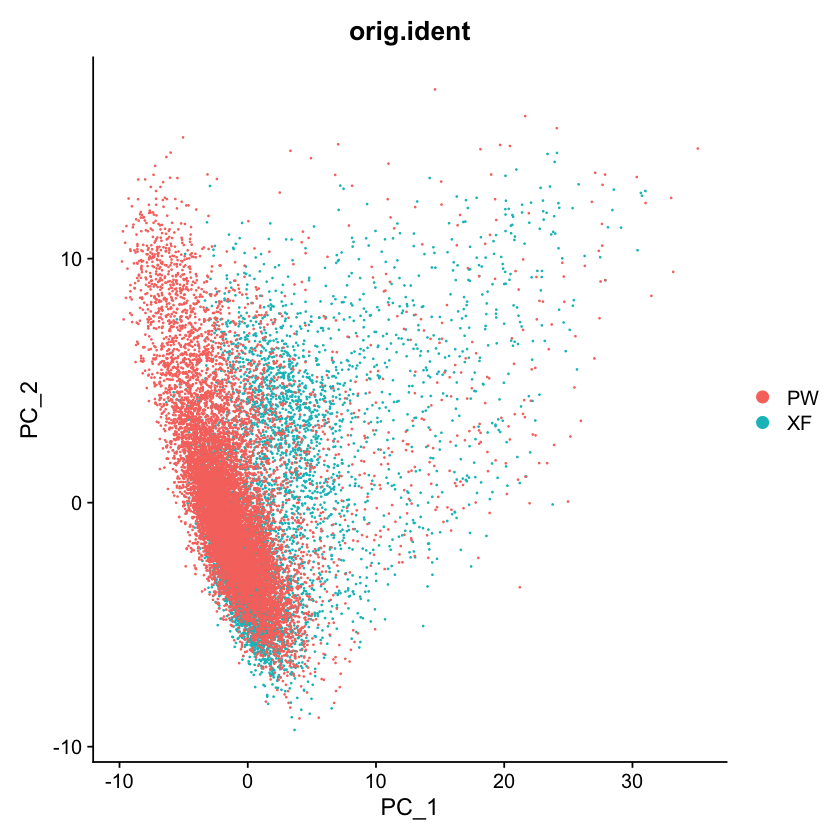

In [18]:
DimPlot(ob.integrated, reduction = "pca",group.by="orig.ident")

In [19]:
ob.integrated <- FindNeighbors(ob.integrated, dims = 1:10)
ob.integrated <- FindClusters(ob.integrated, resolution = c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))
ob.integrated <- RunUMAP(ob.integrated, dims = 1:10)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17359
Number of edges: 512544

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9254
Number of communities: 3
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17359
Number of edges: 512544

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8905
Number of communities: 5
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17359
Number of edges: 512544

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8675
Number of communities: 8
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17359
Number of edges: 512544

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8502
Number of communities: 9
Elapsed time: 2 seconds
Modularity Optim

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:22:12 UMAP embedding parameters a = 0.9922 b = 1.112

11:22:12 Read 17359 rows and found 10 numeric columns

11:22:12 Using Annoy for neighbor search, n_neighbors = 30

11:22:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:22:13 Writing NN index file to temp file /var/folders/91/d8wscw3913132vbq6d1cbt5m0000gn/T//Rtmp2PC7NK/file1fc431fb5f93

11:22:13 Searching Annoy index using 1 thread, search_k = 3000

11:22:17 Annoy recall = 100%

11:22:18 Commencing smooth kNN distance calibra

Warning message:
“package ‘clustree’ was built under R version 4.2.3”
Loading required package: ggraph

Warning message:
“package ‘ggraph’ was built under R version 4.2.3”

Attaching package: ‘ggraph’


The following object is masked from ‘package:sp’:

    geometry




[1] "orig.ident"             "nCount_RNA"             "nFeature_RNA"          
 [4] "scrub_score"            "CMO"                    "Run"                   
 [7] "run_CMO"                "SampleName"             "CellType"              
[10] "Genotype"               "Project"                "Owner"                 
[13] "percent.mito"           "Genotype_2"             "Genotype_3"            
[16] "RNA_snn_res.0.4"        "seurat_clusters"        "percent.mt"            
[19] "hg38_total"             "hg38_dup"               "hg38_libsize"          
[22] "label"                  "nCount_SCT"             "nFeature_SCT"          
[25] "SCT_snn_res.0.5"        "integrated_snn_res.0.1" "integrated_snn_res.0.2"
[28] "integrated_snn_res.0.3" "integrated_snn_res.0.4" "integrated_snn_res.0.5"
[31] "integrated_snn_res.0.6" "integrated_snn_res.0.7" "integrated_snn_res.0.8"
[34] "integrated_snn_res.0.9" "integrated_snn_res.1"

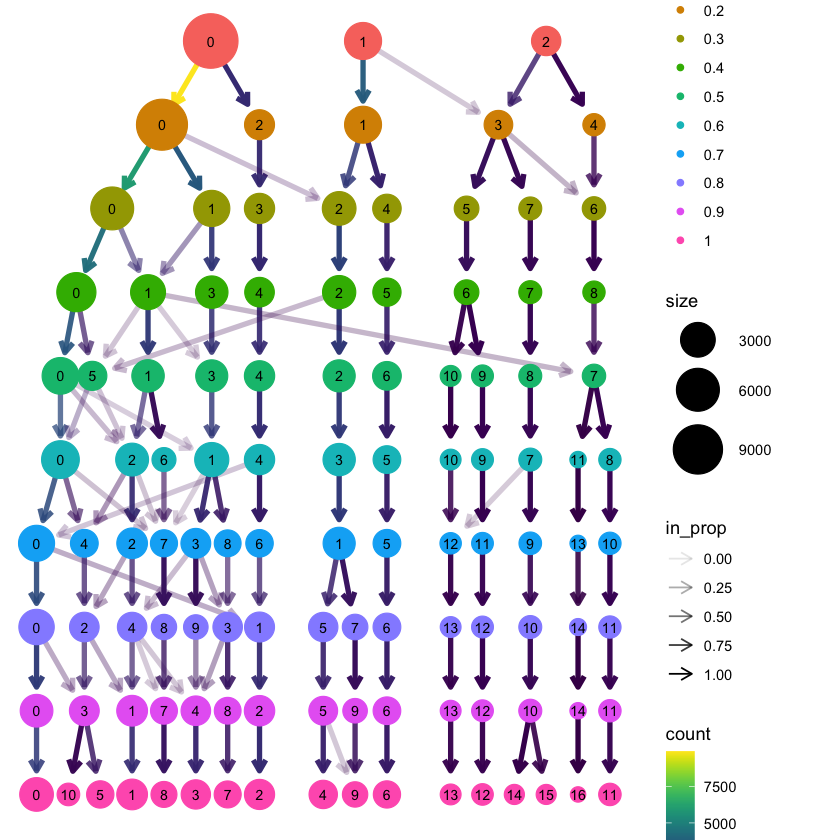

In [20]:
library("clustree")
clustree(ob.integrated@meta.data, prefix = "integrated_snn_res.")
colnames(ob.integrated@meta.data)

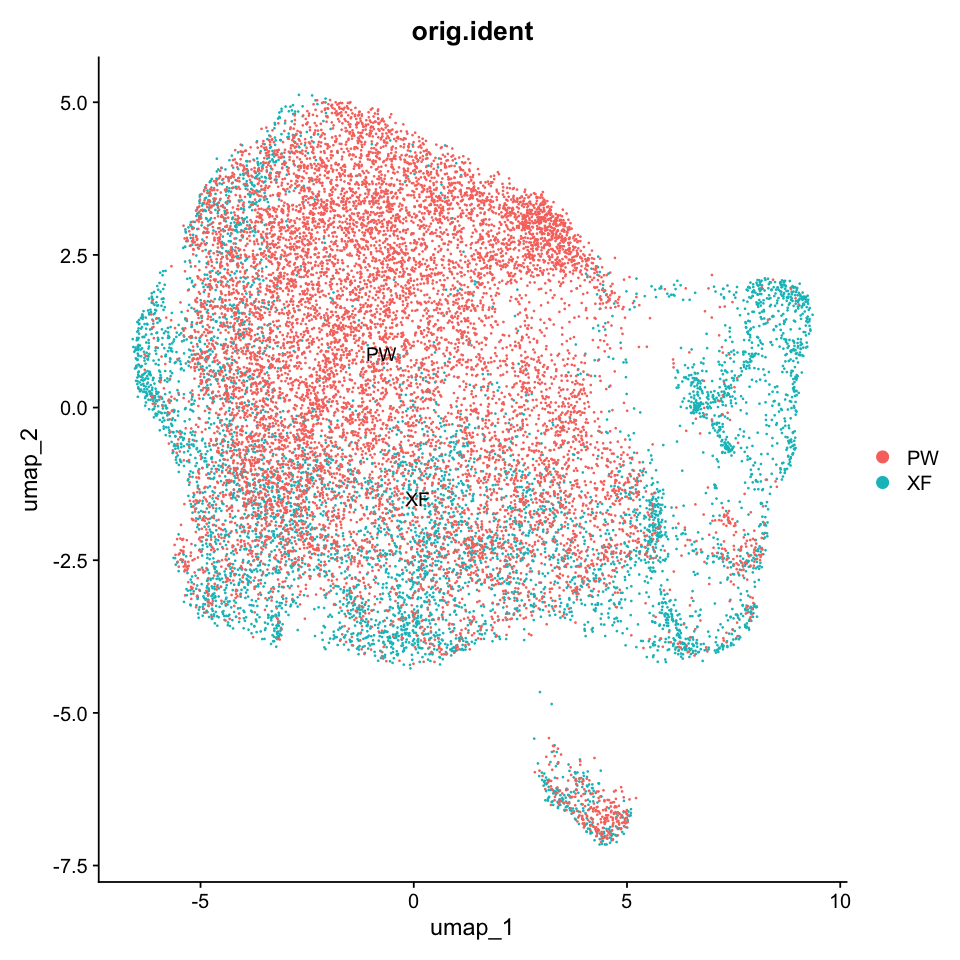

In [21]:
options(repr.plot.height=8,repr.plot.width=8)
DimPlot(ob.integrated, reduction = "umap",label=T,group.by="orig.ident")

In [22]:
colnames(ob.integrated@meta.data)

[1] "orig.ident"             "nCount_RNA"             "nFeature_RNA"          
 [4] "scrub_score"            "CMO"                    "Run"                   
 [7] "run_CMO"                "SampleName"             "CellType"              
[10] "Genotype"               "Project"                "Owner"                 
[13] "percent.mito"           "Genotype_2"             "Genotype_3"            
[16] "RNA_snn_res.0.4"        "seurat_clusters"        "percent.mt"            
[19] "hg38_total"             "hg38_dup"               "hg38_libsize"          
[22] "label"                  "nCount_SCT"             "nFeature_SCT"          
[25] "SCT_snn_res.0.5"        "integrated_snn_res.0.1" "integrated_snn_res.0.2"
[28] "integrated_snn_res.0.3" "integrated_snn_res.0.4" "integrated_snn_res.0.5"
[31] "integrated_snn_res.0.6" "integrated_snn_res.0.7" "integrated_snn_res.0.8"
[34] "integrated_snn_res.0.9" "integrated_snn_res.1"

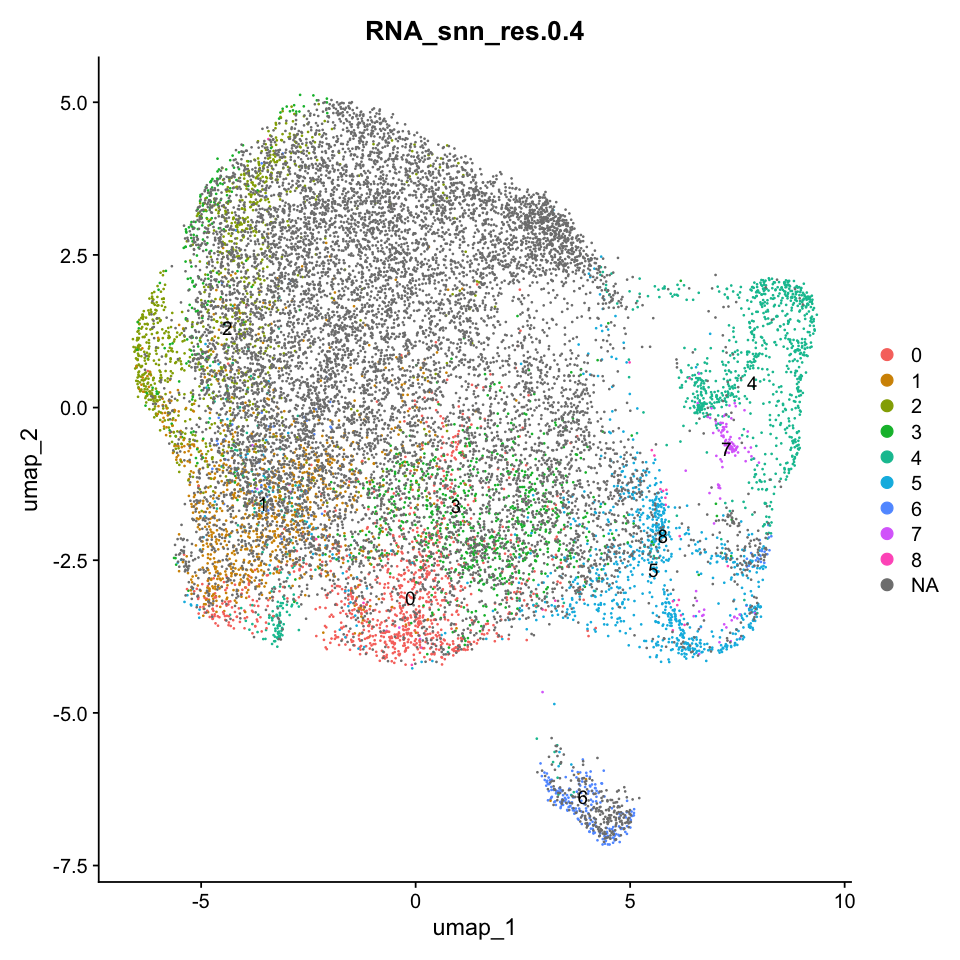

In [23]:
options(repr.plot.height=8,repr.plot.width=8)
DimPlot(ob.integrated, reduction = "umap",group.by="RNA_snn_res.0.4",label=T)

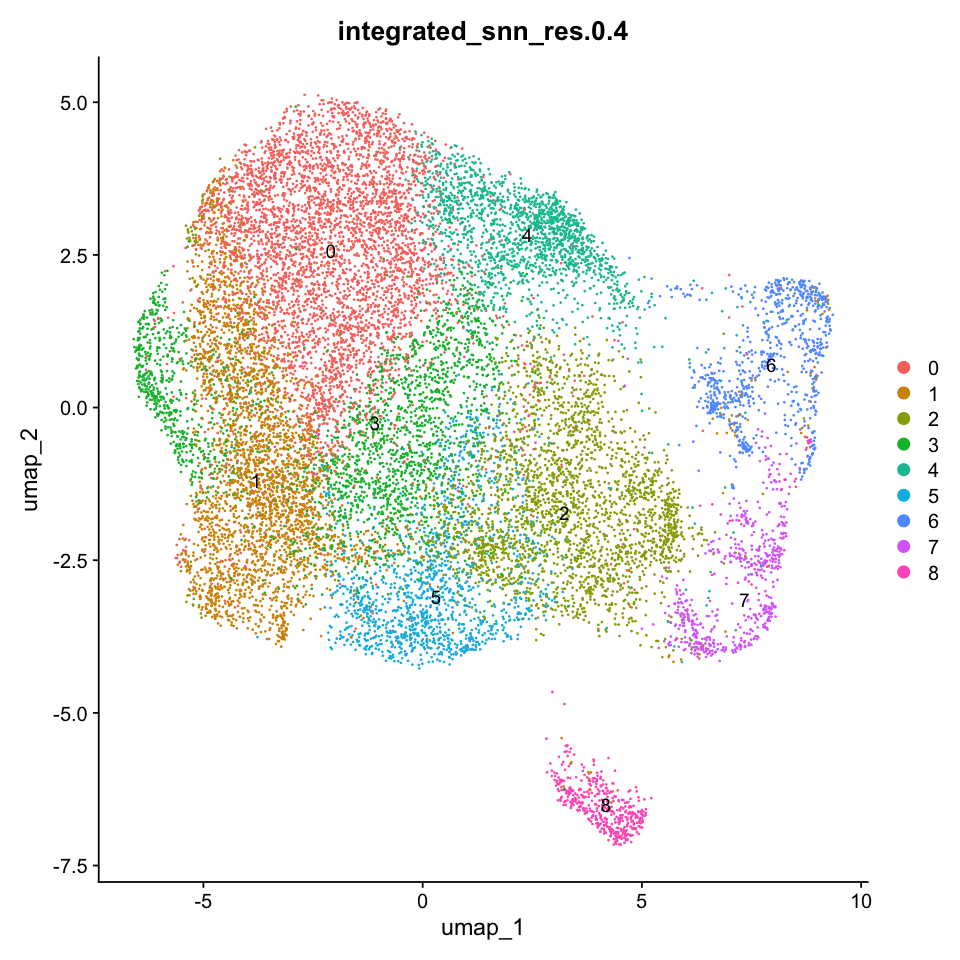

In [24]:
options(repr.plot.height=8,repr.plot.width=8)
DimPlot(ob.integrated, reduction = "umap",group.by="integrated_snn_res.0.4",label=T)

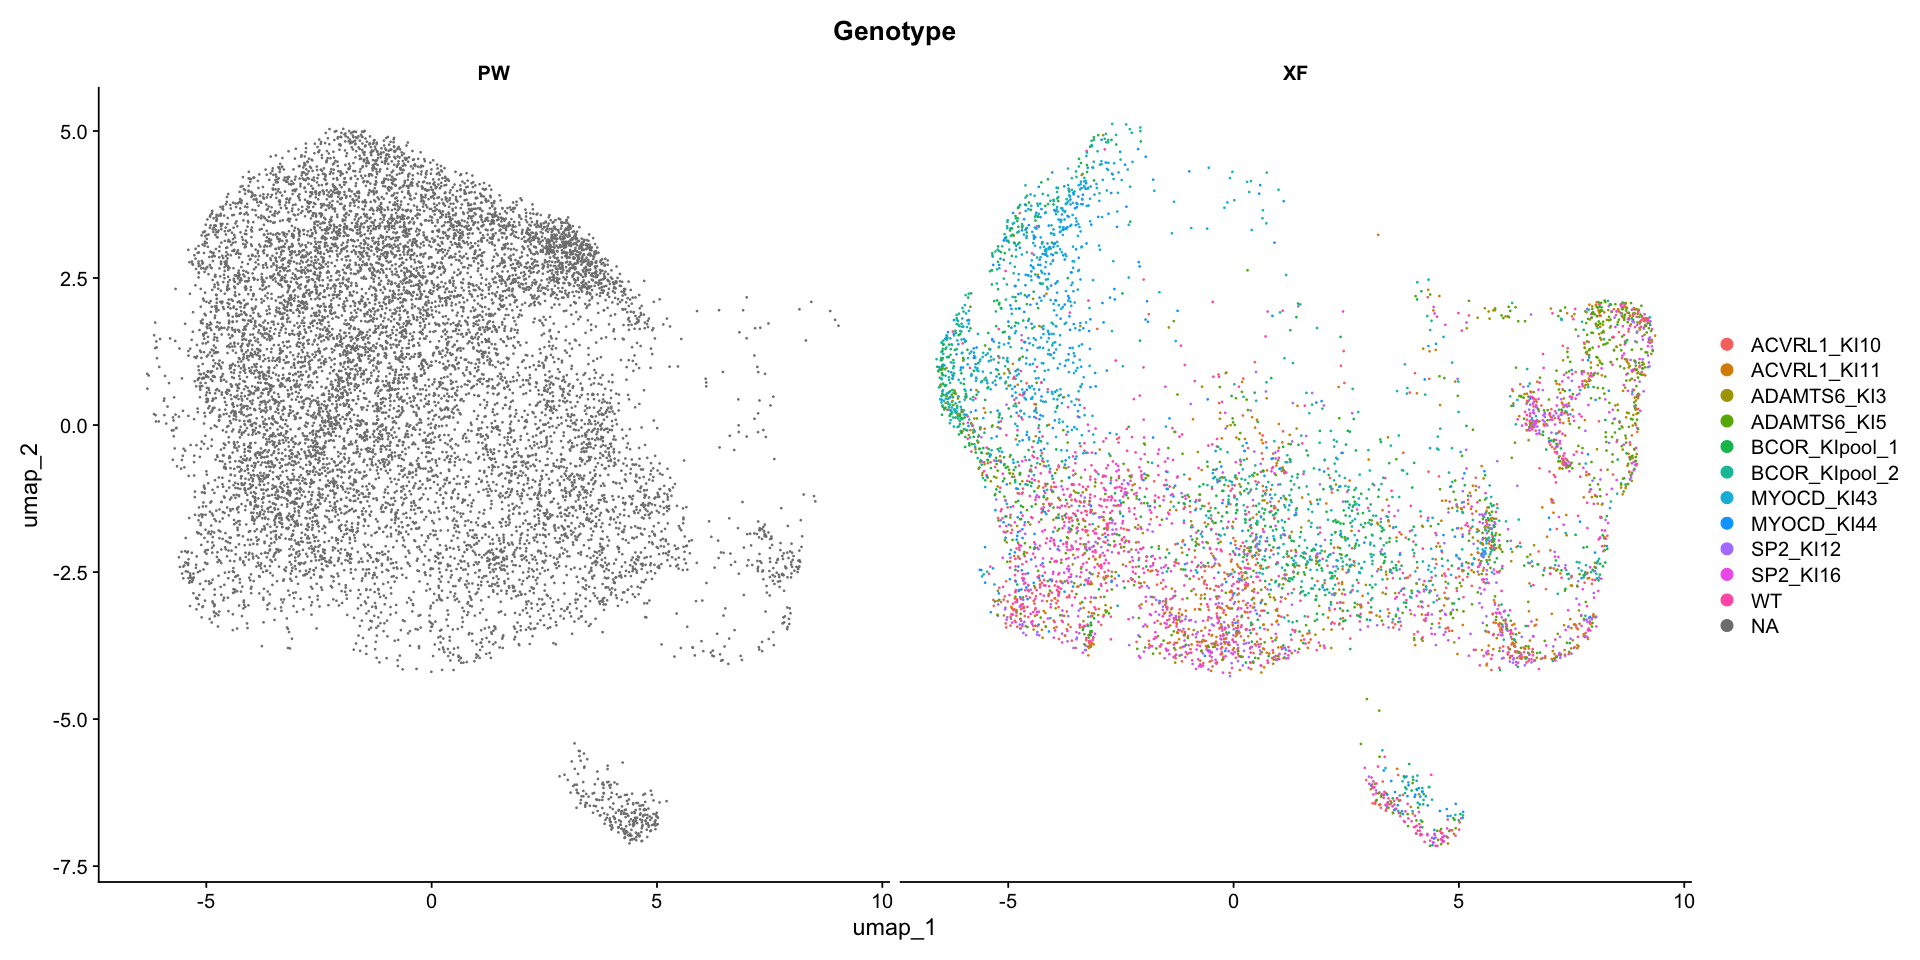

In [35]:
options(repr.plot.height=8,repr.plot.width=16)
DimPlot(ob.integrated, reduction = "umap",group.by="Genotype",label=F,split.by='orig.ident')